In [1]:
import os, sys
sys.path.append(os.path.abspath('../utils'))

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors # type: ignore
import analytic_eqs as cases # type: ignore
import surd as surd # type: ignore
from matplotlib.colors import LinearSegmentedColormap
np.random.seed(10)

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

my_colors = {}
my_colors['redundant'] = mcolors.to_rgb('#003049')
my_colors['unique'] = mcolors.to_rgb('#d62828')
my_colors['synergistic'] = mcolors.to_rgb('#f77f00')
my_colors['red'] = mcolors.to_rgb('#d62828')
my_colors['green'] = mcolors.to_rgb('#6ca13b')
my_gray = mcolors.to_rgb('#000000')
my_gray = tuple([c + (1-c) * 0.8 for c in my_gray])
my_colors['gray'] = my_gray

for key, value in my_colors.items():
    rgb = mcolors.to_rgb(value)
    my_colors[key] = tuple([c + (1-c) * 0.4 for c in rgb])

In [2]:
Nt = 5*10**7            # Number of time steps to perform the integration of the system
samples = Nt-10000      # Number of samples to be considered (remove the transients)
nbins = 51              # Number of bins to disctrize the histogram
nlag = 1                # Time lag to perform the causal analysis

In [3]:
# Define paths for saving/loading data for each system
formatted_Nt = "{:.0e}".format(Nt).replace("+0", "").replace("+", "")
filepath = os.path.join('../data', f"benchmark_source_Nt_{formatted_Nt}.npy")

# Check if data is saved and load it, otherwise generate and save
if os.path.isfile(filepath):
    X = np.load(filepath)
    print(f"Loaded data for benchmark source")
else:
    qs = cases.source(Nt)
    X = np.array([q[-samples:] for q in qs])
    np.save(filepath, X)
    print(f"Generated and saved data for benchmark source")

nvars = X.shape[0]

Loaded data for benchmark source


In [4]:
max_abs = np.percentile(X, 99.99)
max_abs = np.floor(max_abs)
bin_width = 2 * max_abs / (nbins-1)

bins_list = []
for i in range(X.shape[0]):
    bins = np.linspace(-max_abs, max_abs+bin_width, nbins+1)
    bins_list.append(bins)

INFORMATION FLUX FOR SIGNAL 1
    Redundant (R):
        (1, 2)      : 0.0002
        (1, 3)      : 0.0002
        (2, 3)      : 0.0000
        (1, 2, 3)   : 0.0010
    Unique (U):
        (1,)        : 0.0007
        (2,)        : 0.0000
        (3,)        : 0.0000
    Synergystic (S):
        (1, 2)      : 0.0253
        (1, 3)      : 0.0058
        (2, 3)      : 0.0265
        (1, 2, 3)   : 0.9403
    Information Leak: 99.66%


INFORMATION FLUX FOR SIGNAL 2
    Redundant (R):
        (1, 2)      : 0.2001
        (1, 3)      : 0.0000
        (2, 3)      : 0.0000
        (1, 2, 3)   : 0.0047
    Unique (U):
        (1,)        : 0.3185
        (2,)        : 0.1014
        (3,)        : 0.0000
    Synergystic (S):
        (1, 2)      : 0.3714
        (1, 3)      : 0.0026
        (2, 3)      : 0.0000
        (1, 2, 3)   : 0.0012
    Information Leak: 50.23%


INFORMATION FLUX FOR SIGNAL 3
    Redundant (R):
        (1, 2)      : 0.0000
        (1, 3)      : 0.2160
        (2, 3)      :

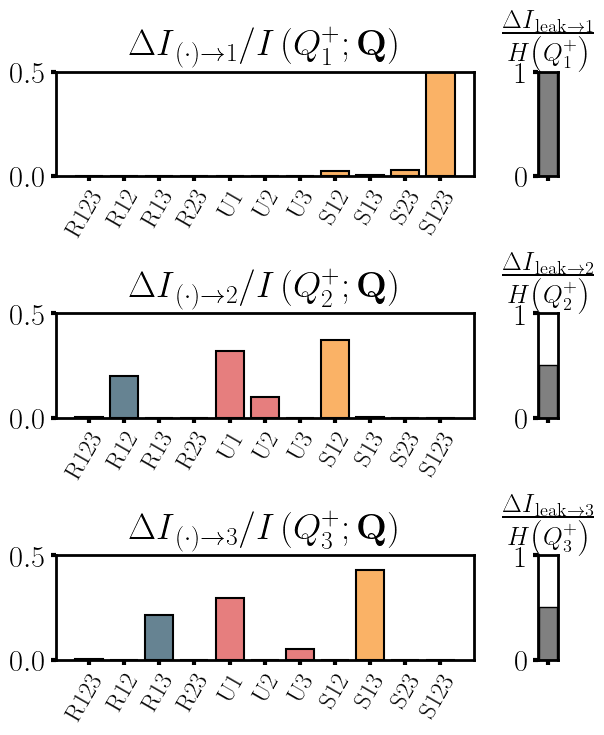

In [5]:
Rd_results, Sy_results, mi_results, info_leak_results = {}, {}, {}, {}
rd_states_results, u_states_results, sy_states_results = {}, {}, {}
    
fig, axs = plt.subplots(nvars, 2, figsize=(10, 2.6*nvars), gridspec_kw={'width_ratios': [nvars*20, 1]})

for i in range(nvars):
    print(f'INFORMATION FLUX FOR SIGNAL {i+1}')

    # Stack the target and sources
    Y = np.vstack([X[i, nlag:], X[:, :-nlag]])

    # Estimate joint histogram
    hist, bins = np.histogramdd(Y.T, bins=[bins_list[i], bins_list[0], bins_list[1], bins_list[2]])

    # Compute SURD contributions
    Rd, Sy, mi, info_leak, rd_states, u_states, sy_states = surd.surd_states(hist)

    # Print results
    surd.nice_print(Rd, Sy, mi, info_leak)

    # Plot SURD
    _ = surd.plot(Rd, Sy, info_leak, axs[i,:], nvars, threshold=-0.01)
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$',pad=12)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1}^+ \\right)}}$',pad=20)
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=18, rotation = 60, ha = 'right', rotation_mode='anchor')
    axs[i,0].set_yticks([0,0.5])
    axs[i,0].set_ylim([0,0.5])

    # Store results
    Rd_results[i + 1] = Rd
    Sy_results[i + 1] = Sy
    mi_results[i + 1] = mi
    info_leak_results[i + 1] = info_leak
    rd_states_results[i + 1] = rd_states
    u_states_results[i + 1] = u_states
    sy_states_results[i + 1] = sy_states

plt.tight_layout(w_pad=-12, h_pad=1)
plt.show()

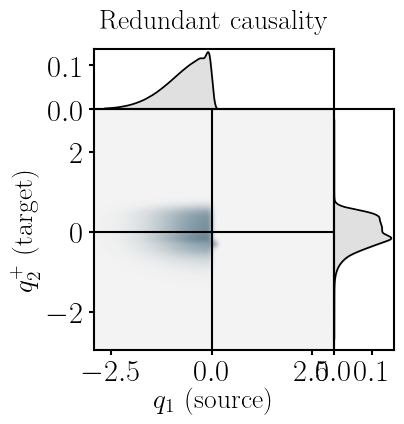

In [6]:
target = 2
source = 1

data = rd_states_results[target][(1, 2)] / Rd_results[target][(1, 2)]
data = data.sum(axis=-1)
data = np.maximum(data, 0)

colors = [my_gray, '#F5F4F4', my_colors['redundant']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data, bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', 'benchmark_source_R12_states.pdf'),
                  title=r'$\rm{Redundant}$  $\rm{causality}$',
                  xlabel=r'$q_{1}$ \rm{(source)}', ylabel=r'$q_{2}^+$ \rm{(target)}',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

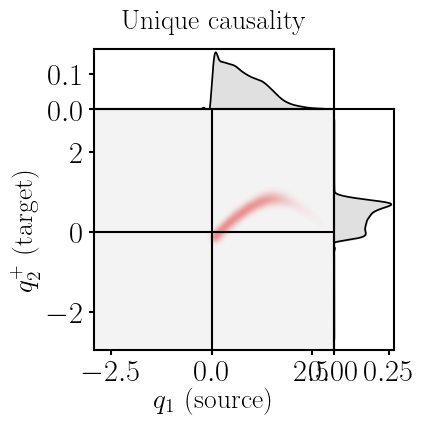

In [7]:
target = 2
source = 1

data = u_states_results[target][(source,)] / Rd_results[target][(source,)]
data = np.maximum(data, 0)

colors = [my_colors['redundant'], '#F5F4F4', my_colors['unique']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data, bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', f'benchmark_source_U{source}_states.pdf'),
                  title=r'$\rm{Unique}$  $\rm{causality}$',
                  xlabel=r'$q_{1}$ \rm{(source)}', ylabel=r'$q_{2}^+$ \rm{(target)}',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

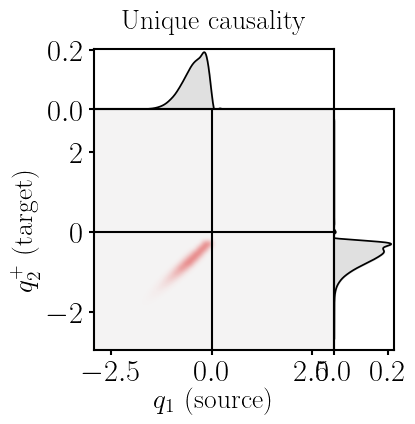

In [8]:
target = 2
source = 2

data = u_states_results[target][(source,)] / Rd_results[target][(source,)]
data = np.maximum(data, 0)

colors = [my_colors['redundant'], '#F5F4F4', my_colors['unique']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data, bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', f'benchmark_source_U{source}_states.pdf'),
                  title=r'$\rm{Unique}$  $\rm{causality}$',
                  xlabel=r'$q_{1}$ \rm{(source)}', ylabel=r'$q_{2}^+$ \rm{(target)}',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

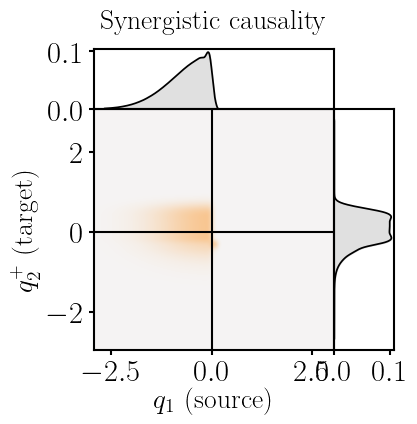

In [9]:
target = 2
source = 2

data = sy_states_results[target][(1,2)] / Sy_results[target][(1,2)]
data = data.sum(axis=-1)
data = np.maximum(data, 0)

colors = [my_colors['unique'], '#F5F4F4', my_colors['synergistic']]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

fig, ax_main, _, _ = surd.plot_states(
                  data=data, bins=bins,
                  target=target, source=source,
                  save_path=os.path.join('../figures', f'benchmark_source_S12_states.pdf'),
                  title=r'$\rm{Synergistic}$  $\rm{causality}$',
                  xlabel=r'$q_{1}$ \rm{(source)}', ylabel=r'$q_{2}^+$ \rm{(target)}',
                  vmax=0.5*np.max(data), vmin=-0.5*np.max(data), 
                  cmap=custom_cmap, norm=False)

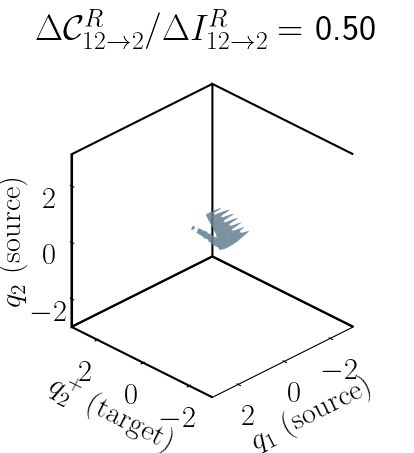

In [10]:
target = 2
data = rd_states_results[target][(1, 2)] / Rd_results[2][(1, 2)]
data = np.maximum(data,0)
level = 0.5
title = f'$\\Delta \\mathcal{{C}}^R_{{12\\to 2}}/\\Delta I^R_{{12\\to 2}}=$ {level:.2f}'
surd.plot_states_3d(data, bins, title, level=level*np.max(data), color = my_colors['redundant'])

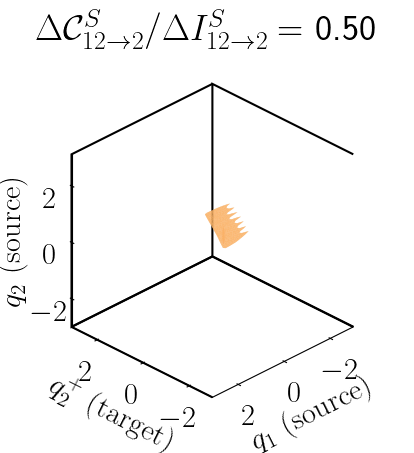

In [11]:
target = 2
data = sy_states_results[target][(1, 2)] / Sy_results[2][(1, 2)]
data = np.maximum(data,0)
level = 0.5
title = f'$\\Delta \\mathcal{{C}}^S_{{12\\to 2}}/\\Delta I^S_{{12\\to 2}}=$ {level:.2f}'
surd.plot_states_3d(data, bins, title, level=level*np.max(data), color = my_colors['synergistic'])